## Modelowanie układów przepływowych - ćwiczenia 
#### (budowa solwera równań płytkiej wody na bazie pakietu PyMPDATA)

In [ ]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

### 0. potrzebne pakiety Pythona

In [2]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot, show_anim
from PyMPDATA import ScalarField, Solver, Stepper, VectorField, Options, boundary_conditions
import math

### 1. opis problemu dyfrakcji płytkiej wody na pojedynczej szczelinie

Dyfrakcja jest zjawiskiem fizycznym dotyczącym fal, najlepiej wytłumaczonym zasadą Huygensa, która mówi, że każdy punkt czoła fali jest źródłem fali kulistej. Jeżeli podamy fale płaską na ścianę rówlnoległą do czoła fali ze szczliną, to po przejściu fali płaskiej przez szczelinę, fala rozprasza się we wszystkich kierunkach. Ponieważ, zgodnie z zasadą Huygensa, każdy punkt czoła fali jest źródłem fali punktowej, to fala w przestrzeni za szczliną jest wynikiem prostokątnego rozkładu źródeł punktowych w miejscu, w którym fala pierwotna opuszcza szczelinę. Fala ta, po przejściu przez szczelinę, pzrestaje być falą płaską i zaczyna się rozchodzić we szystckich kierunkach. Jeżeli po drugiej stronie przestrzeni, postawiony zostanie ekran równolegle do ściany ze szczeliną, to natęzenie fali na ekranie utworzy obraz dyfrakcyjny. Natężenie fali odpowiada wariacji wartości fali ze względu na czas. Obraz dyfrakcyjny jest efektem interferencji ciągłej początkowego rozkładu źródęł punktowych i można ją znaleźć korzytsając z transformaty Fouriera, pod warunkiem, że odległość ekranu od szczeliny jest dużo większa od szerokości szczeliny, tak aby kąt od dowolnego punktu szczeliny do wybranego punktu ekranu był w miarę jednakowy.Wtedy wartość fali w punkcie r i czasie t, jest dana nieprzeliczalną superpozycją fal o źródłach na końcu szczeliny, przy czym interesująca jest jedynie przestrzenna część rozwiązania równania falowego, a więc de facto rozwiązanie równania Helmholtza. Dla źródeł sinusoidalnych o stałej częstości i zgodnej fazie, interferncję tych źróedł można zapisać jako:

$$ F(\vec{r}) = \int_{\Omega} \dfrac{s(\vec{r'})e^{i \vec{k} \cdot (\vec{r}-\vec{r'})}}{4\pi|\vec{r}-\vec{r'}|} \,d^2\vec{r'} \ $$
$$ F(\vec{r}) - \text{Wartość superpozycji fal w punkie r} $$
$$ \vec{r} - \text{Wektor położenia punktu obserwacji} $$
$$ t - \text{Czas obserwacji} $$
$$ s(\vec{r'}) - \text{Źródło sinusoidlane fali w punkcie r'} $$
$$ \Omega - \text{Dwuwymiarowa przestrzeń} $$


Ponieważ, zgodnie z założeniami szczeliny, źródła fal znajdują się na jednej prostej, można zaniedbać całkowanie po drugim wymiarze przestrzeni. Ponadto jeżeli wektor pomiaru jest dużo większy od szerokości szczliny, można przyjąć, że w mianowniku całki występuje wyłącznie długość wektora pomiarowego, a zatem można go wyprowadzić przed całkę. Po tych przekształceniach, wartość fali w punkcie r jest proporcjonalna do transformaty Fouriera "szczeliny". Transformatą Fouriera okna prostokątnego jest funkcja sinc, a ponieważ analizowana jest wariancja pola, to jej obraz będzie kwadratem funkcji sinc.

Nieliniowe równania płytkiej wody, dla niewielkich zaburzeń, przechodzą w liniowe równanie falowe, które powinno skutkować zjawiskiem dyfrakcji. Prędkość fali płytkiej wody można wyznaczyć jako zależność od przyśpieszenia grawitacyjnego i średniej wysokości słupa wody, a więc o ile amplituda fali jest wielokrotnie mniejsza od średniej wysokości słupa wody, nie powinna występować dyspersja.

Ponieważ implementacja samej szczeliny okazała się problematyczna i powodowała wiele artefaktów numerycznych, szczlina została zastąpiona prostokątnym źródłem fali o sinuosidlanym przebiegu czasowym.

Na pozostałych ścianach układu zostaną ustalone odbijające warunki brzegowe, ponieważ pochłaniające warunki brzegowe, z jakiegoś powodu nie działają. Będzie to skutować interferncją fali bezpośredniej i fali odbitej, co może zniekształcić kształt funkcji na brzegach ekranu, ale nie powinno wpływać na jego środek.

Fizycznymi parametrami układu są długość fali i szerokość szczeliny. Ponieważ jednak istnieje pewna dowolność, co do szerokości oczka siatki obliczeniowej, istotny jest jedynie stosunek tych dwóch wielkości, a więc różne szerokości szczliny można symulować różnymi długościami (częstościami) fali. Z powodów praktycznych, rzeczywistym parametrem układu jest częstość fali, ponieważ jest ona łatwiejsza do ustalenia niż długość fali.

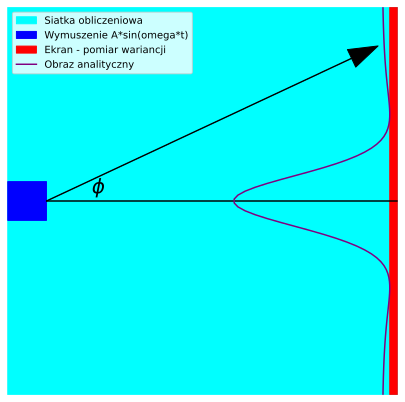

In [3]:
pyplot.figure(figsize=(7,7))
pyplot.axis('off')

color = "blue"
x = np.linspace(0,1)
aaa = np.linspace(-2,2,100)
x_source = np.linspace(0,.1)
yd = 0.45
yg = 0.55
legenda = ["Siatka obliczeniowa","Wymuszenie A*sin(omega*t)","Ekran - pomiar wariancji","Obraz analityczny"]
arrow_kwargs_1 = {'length_includes_head': True, 'head_width': .05}
arrow_kwargs_2 = {'length_includes_head': True, 'head_width': .00}
pyplot.fill_between(x, 0,1, color="cyan")
pyplot.fill_between(x_source, yd,yg, color="blue")
pyplot.fill_between([0.98,1], 0,1, color="red")
pyplot.plot(0.98-0.4*np.sinc(1.5*aaa/np.sqrt(aaa**2+1))**2,(aaa+2)/4,color = "purple")
pyplot.arrow(0.1,0.5,0.85,0.4,color = "black", **arrow_kwargs_1)
pyplot.arrow(0.1,0.5,1,0,color = "black", **arrow_kwargs_2)
pyplot.annotate(f" {r'$\phi$'}", xy=(0.2,0.52), color="black",fontsize = 20)
pyplot.legend(legenda)
pyplot.xlim(0,1)
pyplot.ylim(0,1)
show_plot()

$$ I(sin(\phi)) = I_{max}sinc^2(\dfrac{sin(\phi)d}{\lambda}) $$
$$ \lambda = \dfrac{2v\pi}{\omega} $$
$$ d - \text{szerokość szczliny} $$
$$ v - \text{szybkość fali} $$
$$ \omega - \text{częstość fali} $$
$$ v = \sqrt{gH} $$
$$ g - \text{przyśpieszenie grawitacyjne} $$
$$ H - \text{średnia wysokość słupa wody} $$
$$ I - \text{Natężenie fali (wariancja wysokości wody)} $$

### 2. solwer "hello-world" zbudowany na bazie PyMPDATA

In [4]:
class ShallowWaterEquationsIntegrator:
    def __init__(self, *, h_initial: np.ndarray, options: Options = None):
        """ initializes the solvers for a given initial condition of `h` assuming zero momenta at t=0 """
        options = options or Options(nonoscillatory=True, infinite_gauge=True)
        X, Y, grid = 0, 1, h_initial.shape
        stepper = Stepper(options=options, grid=grid)
        kwargs = {
            'boundary_conditions': [boundary_conditions.Constant(value=0)] * len(grid),
            'halo': options.n_halo,
        }
        kwargs2 = {
            'boundary_conditions': [boundary_conditions.Extrapolated()] * len(grid),
            'halo': options.n_halo,
        }

        advectees = {
            "h": ScalarField(h_initial, **kwargs),
            "uh": ScalarField(np.zeros(grid), **kwargs),
            "vh": ScalarField(np.zeros(grid), **kwargs),
        }
        self.advector = VectorField((
                np.zeros((grid[X] + 1, grid[Y])),
                np.zeros((grid[X], grid[Y] + 1))
            ), **kwargs
        )
        self.solvers = { k: Solver(stepper, v, self.advector) for k, v in advectees.items() }

    def __getitem__(self, key):
        """ returns `key` advectee field of the current solver state """
        return self.solvers[key].advectee.get()
    
    def _apply_half_rhs(self, *, key, axis, g_times_dt_over_dxy):
        """ applies half of the source term in the given direction """
        self[key][:] -= .5 * g_times_dt_over_dxy * self['h'] * np.gradient(self['h'] - bathymetry, axis=axis)

    def _update_courant_numbers(self, *, axis, key, mask, dt_over_dxy):
        """ computes the Courant number component from fluid column height and momenta fields """
        velocity = np.where(mask, np.nan, 0)
        momentum = self[key]
        np.divide(momentum, self['h'], where=mask, out=velocity)

        # using slices to ensure views (over copies)
        all = slice(None, None) 
        all_but_last = slice(None, -1)
        all_but_first_and_last = slice(1, -1)

        velocity_at_cell_boundaries = velocity[( 
            (all_but_last, all),
            (all, all_but_last),
        )[axis]] + np.diff(velocity, axis=axis) / 2 
        courant_number = self.advector.get_component(axis)[(
            (all_but_first_and_last, all),
            (all, all_but_first_and_last)
        )[axis]]
        courant_number[:] = velocity_at_cell_boundaries * dt_over_dxy[axis]
        assert np.amax(np.abs(courant_number)) <= 1

    def set_boundry_conditions(self):
        advectee = self["h"]
        advectee[:,0] = advectee[:,1]
        advectee[:,-1] = advectee[:,-2]

    def __call__(self,sources: dict, *, nt: int, g: float, dt_over_dxy: tuple, outfreq: int, eps: float=1e-7):
        """ integrates `nt` timesteps and returns a dictionary of solver states recorded every `outfreq` step[s] """
        output = {k: [] for k in self.solvers.keys()}
        for it in range(nt + 1): 
            for key in self.solvers.keys():
                if sources[key] == None:
                    continue
                advectee = self[key]
                advectee[slit] = sources[key](it)
                advectee[bathymetry < 1e-2] = 0
            if it != 0:
                mask = self['h'] > eps
                self.set_boundry_conditions()
                for axis, key in enumerate(("uh", "vh")):
                    self._update_courant_numbers(axis=axis, key=key, mask=mask, dt_over_dxy=dt_over_dxy)
                self.solvers["h"].advance(n_steps=1)
                self.set_boundry_conditions()
                for axis, key in enumerate(("uh", "vh")):
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
                    self.solvers[key].advance(n_steps=1)
                    self._apply_half_rhs(key=key, axis=axis, g_times_dt_over_dxy=g * dt_over_dxy[axis])
            if it % outfreq == 0:
                for key in self.solvers.keys():
                    output[key].append(self[key].copy())
        return output


### 3. Przykładowa symulacja

In [5]:
grid = (50, 40)
dx1 = 50/grid[0]
dy1 = 40/grid[1]
dt = 0.25
dt_over_dx = dt/dx1
dt_over_dy = dt/dy1

bathymetry = np.tile(np.linspace(1,1,grid[1]),(grid[0],1))

Y,X = np.meshgrid(np.linspace(0,1,grid[1]),np.linspace(0,1,grid[0]))

width = 0.1

#bathymetry[np.logical_and(X>0.3,X<0.4)] = 0
bathymetry[np.logical_and(-width/2 <(Y-0.5),(Y-0.5) <width/2)] = 1

slit = np.logical_and(X<=0.1,abs(Y-0.5) < width/2)


h_initial = bathymetry.copy()

h_initial_c3 = h_initial.copy()
h_initial_c6 = h_initial.copy()
h_initial_c3_dt2 = h_initial.copy()
h_initial_c6_dt2 = h_initial.copy()



sources_c3 = {}
omega_c3 = 0.3
amplitude = 0.025
offset = 1
g = 10
outframe = 1


sources_c3["h"] = lambda t: offset + amplitude*np.sin(omega_c3*(t*dt))
sources_c3["uh"] = None
sources_c3["vh"] = None


sources_c6 = {}
omega_c6 = 0.6
sources_c6["h"] = lambda t: offset + amplitude*np.sin(omega_c6*(t*dt))
sources_c6["uh"] = None
sources_c6["vh"] = None

sources_c1 = {}
omega_c1 = 0.1
sources_c1["h"] = lambda t: offset + amplitude*np.sin(omega_c1*(t*dt))
sources_c1["uh"] = None
sources_c1["vh"] = None

dt2 = dt/2
outframe2 = outframe*2

sources_c3_dt2 = {}
#sources_c3_dt2["h"] = lambda t,x: offset + amplitude*np.sin(omega_c3*(t*dt2 - x*dx1/np.sqrt(g*offset) ))
sources_c3_dt2["h"] = lambda t: offset + amplitude*np.sin(omega_c3*(t*dt2))
sources_c3_dt2["uh"] = None
sources_c3_dt2["vh"] = None

sources_c6_dt2 = {}
sources_c6_dt2["h"] = lambda t: offset + amplitude*np.sin(omega_c6*(t*dt2))
sources_c6_dt2["uh"] = None
sources_c6_dt2["vh"] = None

nt = 400

nt2 = nt*2

dt2_over_dx = dt2/dx1
dt2_over_dy = dt2/dy1

output_c3 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial_c3
)(
    sources= sources_c3,nt=nt, g=g, dt_over_dxy=(dt_over_dx,dt_over_dy), outfreq=outframe
)

output_c6 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial_c6
)(
    sources= sources_c6,nt=nt, g=g, dt_over_dxy=(dt_over_dx,dt_over_dy), outfreq=outframe
)



output_c3_dt2 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial_c3_dt2
)(
    sources= sources_c3_dt2,nt=nt2, g=g, dt_over_dxy=(dt2_over_dx,dt2_over_dy), outfreq=outframe2
)

output_c6_dt2 = ShallowWaterEquationsIntegrator(
    h_initial=h_initial_c6_dt2
)(
    sources= sources_c6_dt2,nt=nt2, g=g, dt_over_dxy=(dt2_over_dx,dt2_over_dy), outfreq=outframe2
)


### 4. Wizualizacja

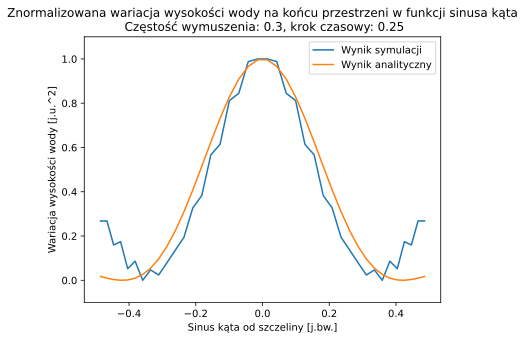

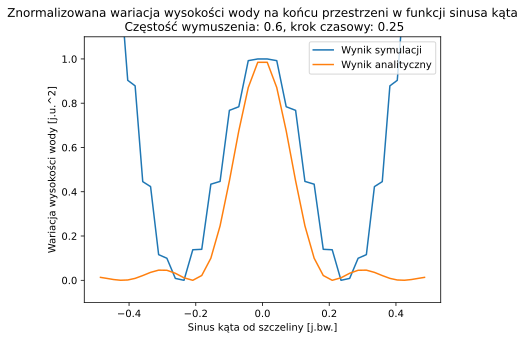

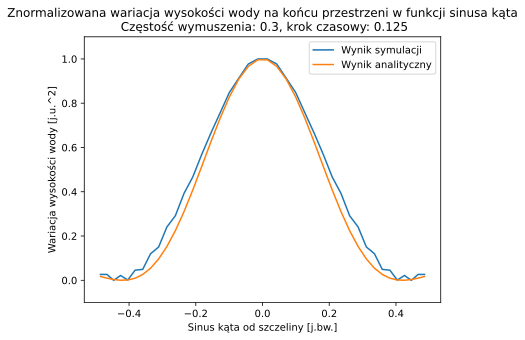

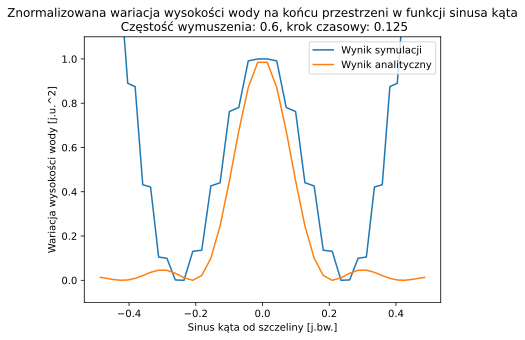

In [6]:

def plot_spectrum(output,omega,g = 10, offset = 1, width = 0.05,nb = -1, nt = 240,dt = dt):
    if nb == -1:
        nb = round(2*math.pi/omega)
    spectrum = np.array(output["h"][0][0][:].copy())
    spectrum = spectrum*0
    for frame in range(nb,nt):
        spectrum += np.array((output["h"][frame][-1][:]-offset)**2)
    y = np.linspace(-0.5,0.5,grid[1])
    sinphi = y/np.sqrt(y**2+0.9**2)
    velocity = math.sqrt(g*offset)
    wavelength = velocity/2/math.pi/omega
    Teor = lambda sp: np.sinc(width*dy1*40*sp/wavelength)**2
    spectrum_norm = (spectrum-min(spectrum))
    spectrum_norm = spectrum_norm/spectrum_norm[round(len(spectrum_norm)/2)]

    fig, ax = pyplot.subplots(1,1)
    ax.plot(sinphi,spectrum_norm)
    ax.plot(sinphi,Teor(sinphi))
    ax.set_title(f"Znormalizowana wariacja wysokości wody na końcu przestrzeni w funkcji sinusa kąta\n Częstość wymuszenia: {omega}, krok czasowy: {dt}")
    ax.set_xlabel("Sinus kąta od szczeliny [j.bw.]")
    ax.set_ylabel("Wariacja wysokości wody [j.u.^2]")
    ax.set_ylim(-0.1,1.1)
    ax.legend(["Wynik symulacji","Wynik analityczny"])
    return fig, ax


fig1 = plot_spectrum(output_c3,omega=omega_c3,width=width)
show_plot()
fig2 = plot_spectrum(output_c6,omega=omega_c6,width=width)
show_plot()



fig3 = plot_spectrum(output_c3_dt2,omega=omega_c3,width=width,dt=dt2)
show_plot()
fig4 = plot_spectrum(output_c6_dt2,omega=omega_c6,width=width,dt=dt2)
show_plot()

W celu sprawdzenia zgodności modelu ze wzroem teoretycznym, przeanlizowano dwie częstotliowści 0.3 Hz oraz 0.6 Hz, dla dwóch różnych rozdzielczości czasowych 0.25 s oraz 0.125 s. Dla częstości 0.3 Hz, wynik analityczny bardzo dobrze opisuje uzyskane wyniki symulacji i poprawnie odwzorowywuje miejsca zerowe. Dla kątów bliskich brzegu siatki, wynik symulacji jest wyższy od wyniku analitycznego, co prawdopodobnie jest wynikiem intreferencji fali odbitej od brzegu i fali bezpośredniej. Poprawniej byłoby ustawić warunki brzegowe na pochłaniające zamiast odbijających, ale z jakiegoś powodu, warunki pochłaniające nie działają poprawnie. Wobec tego należy się liczyć z pewnym zaburzeniem wyników blisko brzegów bocznych siatki. Dla częstości 0.6 Hz, efekty interferencji brzegowej się nasilają, dlatego nalizowana będzie tylko centralna część widma. Dla tej częstości, wynik symulacji dużo gorzej pokrywa się z wynikiem analitycznym, choć szerokość widma analitycznego i symulacyjnego jest zbliżona. Dla wyższej częstości, miejsca zerowe rozwiązania analitycznego już niekoniecznie pokrywają sięz symulacją, aczkolwiek możliwe, że efekty brzegowe przeunęły miejsca zerowe w symulacji i dla poprawynych warunków brzegowych, rozwiązanie byłoby bliższe analitycznego. Następnym krokiem było zwiększenie rozdzielczości czasowej i rozpatrzenie jej wpływu na wynik symulacji. Dla zwiększonej rozdizelczości czasowej i częstości 0.3 Hz, wynik symulacyjny się wygładza i pokrywa się z centralną częscią rozwiązania analitycznego. Dla brzegów rozwiązanie w dalszym ciągu odbiega od teorii. Dla zwiększonej częstości z krótszym krokiem czasowym, niewiele się zmienia. Widmo symulacyjne, choć nie zgadza się w pełni z analitycznym, to posiadają zbliżoną szerokość. 

Wnioski:
Ocena zgodności wyników symulacji z teorią jest utrudniona przez warunki brzegowe, które zaburzają kształt widma przy brzegach bocznych siatki obliczeniowej. Dla niskich częstości centralna część widma zgadza się z rozwiązaniem analitycznym, które ponadto, poprawnie odtwarza miejsca zerowe widma. Dla wyższych częstość widmo symulacyjne zaczyna odbiegać od analitycznego, aczkolwiek, wynik symulacji i widmo teoretyczne posiadają zbliżoną szerokość. Zwiększenie rozdzielczości czaoswej dla niższysch częstości, daje doskonałą zbieżność w centralnej części widma i bardzo dobrą na jego brzegach, ponieważ, z jakiegoś powodu, redukuje efekty brzegowe. Dodatkowo, uzyskane widmo jest bardziej gładkie, w przeciwieństwie do dłuższego kroku czasowego, dla którego występują "półeczki" z dwóch oczek siatki o niemal jednakowych wartościach, co prawodpodobnie jest jakiegoś rozdaju artefaktem numerycznym. Efekt wygładznia funkcji jest dużo mniejszy dla brzegów widma. Dla wyższych częstości, podowojenie kroku czasowego nie przyniosło żadnej zauważalnej zmiany. Zmiejszenie kroku czasowego dla większych częstości nie redukuje "półeczek" numerycznych, jak to miało miejsce dla mniejszej częstości, a same "półeczki" są dużo bardziej wyraźne. Równania płytkiej wody dobrze modelują dyfrakcję dla niskich częstości i jakość rozwiązania poprawia się wraz z rozdzielczością czasową. Dla wyżsych częstości, wyniki nie są odległe od analitycznych, ale nie są też poprawne, a zwiększenie rozdzielczości czasowej nie wpływa w znaczący sposób na widmo. Numeryczne modelowanie dyfrakcji jest inhenerntnie obarczone problemem zakresu częstości, ponieważ dla zbyt niskich czestości, trzeba zwiększać długość symulacji wraz ze zmiejszeniem częstości, tak aby w układzie mógł się wyrobić stan ustalony (w przeiwnym razie układ będzie posiadał dodatkowe częstliwości), natomiast wyższe częstości wymagają stosunkowego zmniejszania kroku czasowego, tak aby częstość sygnału nie przeszła ponad częstliwość Nyquista powyżej której, algorytm będzie widział inną częstotliwość od rzeczywiście zadanej.